<a href="https://colab.research.google.com/github/greymouse1/spatialanalysis/blob/main/continuity_multiple_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is licenced under MIT licence.

Author: Nikola G.

Credits:

Tutorial from Momepy package website at http://docs.momepy.org/en/stable/user_guide/graph/coins.html
based on paper by Tripathy et al. (2020)

OpenAI. (2024). ChatGPT (version 4) [Large language model]. OpenAI. https://openai.com/chatgpt



Tripathy, P., Rao, P., Balakrishnan, K., & Malladi, T. (2020). An open-source tool to extract natural continuity and hierarchy of urban street networks. Environment and Planning B: Urban Analytics and City Science. http://dx.doi.org/10.1177/2399808320967680

In [1]:
!pip install osmnx > /dev/null 2>&1
!pip install momepy > /dev/null 2>&1
!pip install mapclassify>=2.4.0 > /dev/null 2>&1 # install mapclassify with version >=2.4.0
!pip install powerlaw > /dev/null 2>&1
import osmnx as ox
import geopandas as gpd
import momepy
import mapclassify
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import powerlaw
from collections import defaultdict, Counter
from shapely.geometry import MultiLineString, LineString, Point

In [2]:
def naturalCities(currentCity,folderPath,cityName):
  # Retrieve the graph within the polygon's boundaries
  # This will pull OSM data from inside the polygon and create a networkX graph

  graph = ox.graph_from_polygon(
      currentCity,
      network_type='drive',  # Choose network type (e.g., 'drive', 'walk', 'bike', etc.)
      simplify=True,         # Simplify graph (remove unnecessary nodes)
      retain_all=False,      # Keep only the largest connected component
      truncate_by_edge=False  # Truncate by edge to keep nodes near the edge
  )

  # Reproject graph
  # Choice of final projection is automatic, original must be WGS84

  city_streets = ox.projection.project_graph(graph)

  # Create gdf from graph so it can be used later on

  city_gdf = ox.graph_to_gdfs(
      ox.convert.to_undirected(city_streets),
      nodes=False,
      edges=True,
      node_geometry=False,
      fill_edge_geometry=True,
  )

  # Calculate continuity from the gdf

  continuity = momepy.COINS(city_gdf, angle_threshold=135, flow_mode=False)

  # Pull out stroke

  city_stroke_gdf = continuity.stroke_gdf()

  # Save stroke to .shp
  shapefile_path = os.path.join(folderPath, f"polygon_{cityName}.shp")
  city_stroke_gdf.to_file(shapefile_path)
#--------------------------------------------------------------------------------------------------------------
  # Initialize the vertex-to-linestring mapping
  vertex_to_linestring = defaultdict(list)

  # Iterate over geometries and map vertices to LineStrings (handle MultiLineString)
  for idx, geom in city_stroke_gdf.geometry.items():
      if isinstance(geom, LineString):  # Process single LineString
          for point in geom.coords:
              vertex_to_linestring[Point(point)].append(idx)
      elif isinstance(geom, MultiLineString):  # Process MultiLineString
          # For each LineString in MultiLineString
          for subline in geom.geoms:
              for point in subline.coords:
                  vertex_to_linestring[Point(point)].append(idx)

  # Initialize a dictionary to store the connection counts for each line
  line_connections = defaultdict(int)

  # Iterate over the geometries again to count connections
  for idx, geom in city_stroke_gdf.geometry.items():
      if isinstance(geom, LineString):  # Process single LineString
          connections = []  # Use a list to count multiple connections
          for point in geom.coords:
              for connected_line in vertex_to_linestring[Point(point)]:
                  if connected_line != idx:
                      connections.append(connected_line)  # Add connection to the list
          line_connections[idx] = len(connections)  # Store the total number of connections
      elif isinstance(geom, MultiLineString):  # Process MultiLineString
          # For each LineString in MultiLineString
          for subline in geom.geoms:
              connections = []  # Use a list to count multiple connections for each subline
              for point in subline.coords:
                  for connected_line in vertex_to_linestring[Point(point)]:
                      if connected_line != idx:
                          connections.append(connected_line)  # Add connection to the list
              # Store the connection count for each subline (if necessary)
              # For now, we store the count for the entire MultiLineString
              line_connections[idx] = len(connections)


  # Extract degree (number of connections) values
  degree_values = list(line_connections.values())

  # Count frequencies of degree values
  degree_counts = Counter(degree_values)

  # Extract x (degrees) and y (frequencies)
  x = np.array(list(degree_counts.keys()))       # Unique degree values
  y = np.array(list(degree_counts.values()))    # Frequency of each degree

  # Fit the degree distribution to a power-law model
  fit = powerlaw.Fit(degree_values)
  print(f"Alpha: {fit.alpha}")
  print(f"xmin: {fit.xmin}")

  # Get alpha and xmin (scaling parameter and lower bound for the power-law fit)
  alpha = fit.alpha
  xmin = fit.xmin

  # Get the p-value from the goodness-of-fit test
  p_value = fit.power_law.KS()

  print(f"p-value: {p_value}")
  print("-----------------------")
  # Compare the power-law fit with an alternative distribution (e.g., exponential)
  R, p_alt = fit.distribution_compare('power_law', 'exponential')
  print(f"Log-likelihood ratio (R): {R}")
  print(f"p-value for comparison: {p_alt}")

  # Plot the data and the fitted power law
  fig = fit.plot_pdf(marker='o', color='blue', markersize=4, label='Empirical Data')
  fit.power_law.plot_pdf(ax=fig, color='red', linestyle='--', linewidth=1, label='Power Law Fit')

  # Add legend and labels
  plt.xlabel("Degree (Connections)")
  plt.ylabel("Frequency")
  plt.legend()

  output_path_power = os.path.join(folderPath, f"power_{cityName}.png")
  plt.savefig(output_path_power, dpi=600, bbox_inches="tight")

  print(f"Plot for power fit for {cityName} saved to {output_path_power}")
  plt.clf() # clear existing plot and make space for a new one

#-------------------------
  # Add connections to original gdf
  city_stroke_gdf['n_connections'] = degree_values

  # Calculate heavy tailed classification
  classifier = mapclassify.HeadTailBreaks(degree_values)

  # Get classification details
  class_intervals = classifier.bins  # Class boundaries
  counts = classifier.counts         # Number of features in each class
  labels = classifier.yb             # Class labels for each feature

  # Save classification output to a text file
  classifier_path = os.path.join(folderPath, f"map_classifier_output_{cityName}.txt")

  with open(classifier_path, "w") as file:
      file.write("HeadTailBreaks Classification\n")
      file.write("================================\n")
      file.write("Class Intervals:\n")
      file.write(", ".join(f"{b:.2f}" for b in class_intervals) + "\n\n")
      file.write("Counts in Each Class:\n")
      file.write(", ".join(str(c) for c in counts) + "\n\n")
      file.write("Statistical indicators for power law:" + "\n\n")
      file.write("Alpha: " + str(alpha) + "\n")
      file.write("xmin: " + str(xmin) + "\n")
      file.write("p-value: " + str(p_value) + "\n")
      file.write("Log-likelihood ratio (R): " + str(R) + "\n")
      file.write("p-value for comparison: " + str(p_alt) + "\n")


  print(f"Classifier output saved to {classifier_path}")

  # Show the classifier (lower and upper bounds plus count)
  print(classifier)

  city_stroke_gdf.plot(
      figsize=(15, 15),
      cmap="viridis_r",
      column="n_connections",
      legend=True,
      scheme="headtailbreaks",
  ).set_axis_off()

  output_path_figure = os.path.join(folderPath, f"figure_{cityName}.png")
  plt.savefig(output_path_figure, dpi=600, bbox_inches="tight")

  print(f"Plot for {cityName} saved to {output_path_figure}")

  plt.clf() # clear existing plot and make space for a new one
  # Histogram for n_segments

  city_stroke_gdf['n_connections'].plot(kind='hist', bins=40, title='n_segments')
  plt.gca().spines[['top', 'right',]].set_visible(False)
  output_path_histogram = os.path.join(folderPath, f"histogram_{cityName}.png")
  plt.savefig(output_path_histogram, dpi=300, bbox_inches="tight")
  print(f"Histogram for {cityName} saved to {output_path_histogram}")
  plt.clf() # clear existing plot and make space for a new one

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
New GeoDataFrame for polygon at index 0 is loaded


/usr/local/lib/python3.10/dist-packages/momepy/coins.py:103: UserWarning: Lines are between points dict_keys([(691918.4661335435, 9189330.531313427), (691915.6479395456, 9189324.204884572)]) identical. Please revise input data to ensure no lines are identical or overlapping. You can check for duplicates using `gdf.geometry.duplicated()`. Assumingan angle of 0 degrees.
  self._best_link()
<ipython-input-2-f75b4d7caa5f>:38: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city_stroke_gdf.to_file(shapefile_path)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke_group' to 'stroke_gro'
  ogr_write(
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Alpha: 3.387511877543187
xmin: 14.0
p-value: 0.02890670980231891
-----------------------
Log-likelihood ratio (R): 78.09700663675441
p-value for comparison: 1.7784388530493717e-09


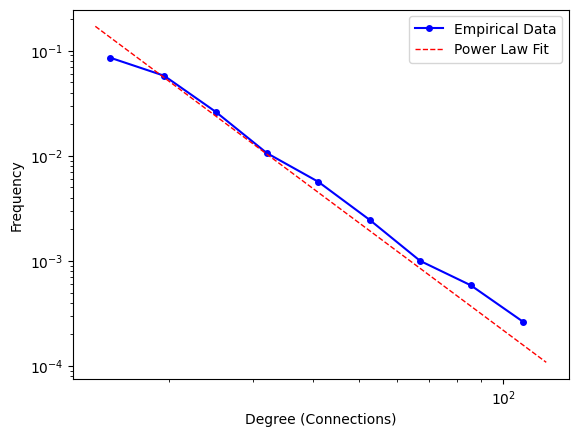

Plot for power fit for 0 saved to output_polygons/polygon_0/power_0.png
Classifier output saved to output_polygons/polygon_0/map_classifier_output_0.txt
HeadTailBreaks

    Interval       Count
------------------------
[  0.00,   3.33] | 23281
(  3.33,   7.93] |  5357
(  7.93,  14.63] |  1650
( 14.63,  25.32] |   504
( 25.32,  42.58] |   135
( 42.58,  64.00] |    40
( 64.00,  84.00] |    15
( 84.00,  98.91] |     6
( 98.91, 107.60] |     3
(107.60, 115.50] |     1
(115.50, 123.00] |     1
Plot for 0 saved to output_polygons/polygon_0/figure_0.png
Histogram for 0 saved to output_polygons/polygon_0/histogram_0.png
New GeoDataFrame for polygon at index 1 is loaded


<ipython-input-2-f75b4d7caa5f>:38: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city_stroke_gdf.to_file(shapefile_path)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke_group' to 'stroke_gro'
  ogr_write(


Calculating best minimal value for power law fit
Alpha: 3.0235428511869524
xmin: 13.0
p-value: 0.033629029325999205
-----------------------
Log-likelihood ratio (R): 52.517277165642206
p-value for comparison: 7.811737651565991e-07


Values less than or equal to 0 in data. Throwing out 0 or negative values


<Figure size 640x480 with 0 Axes>

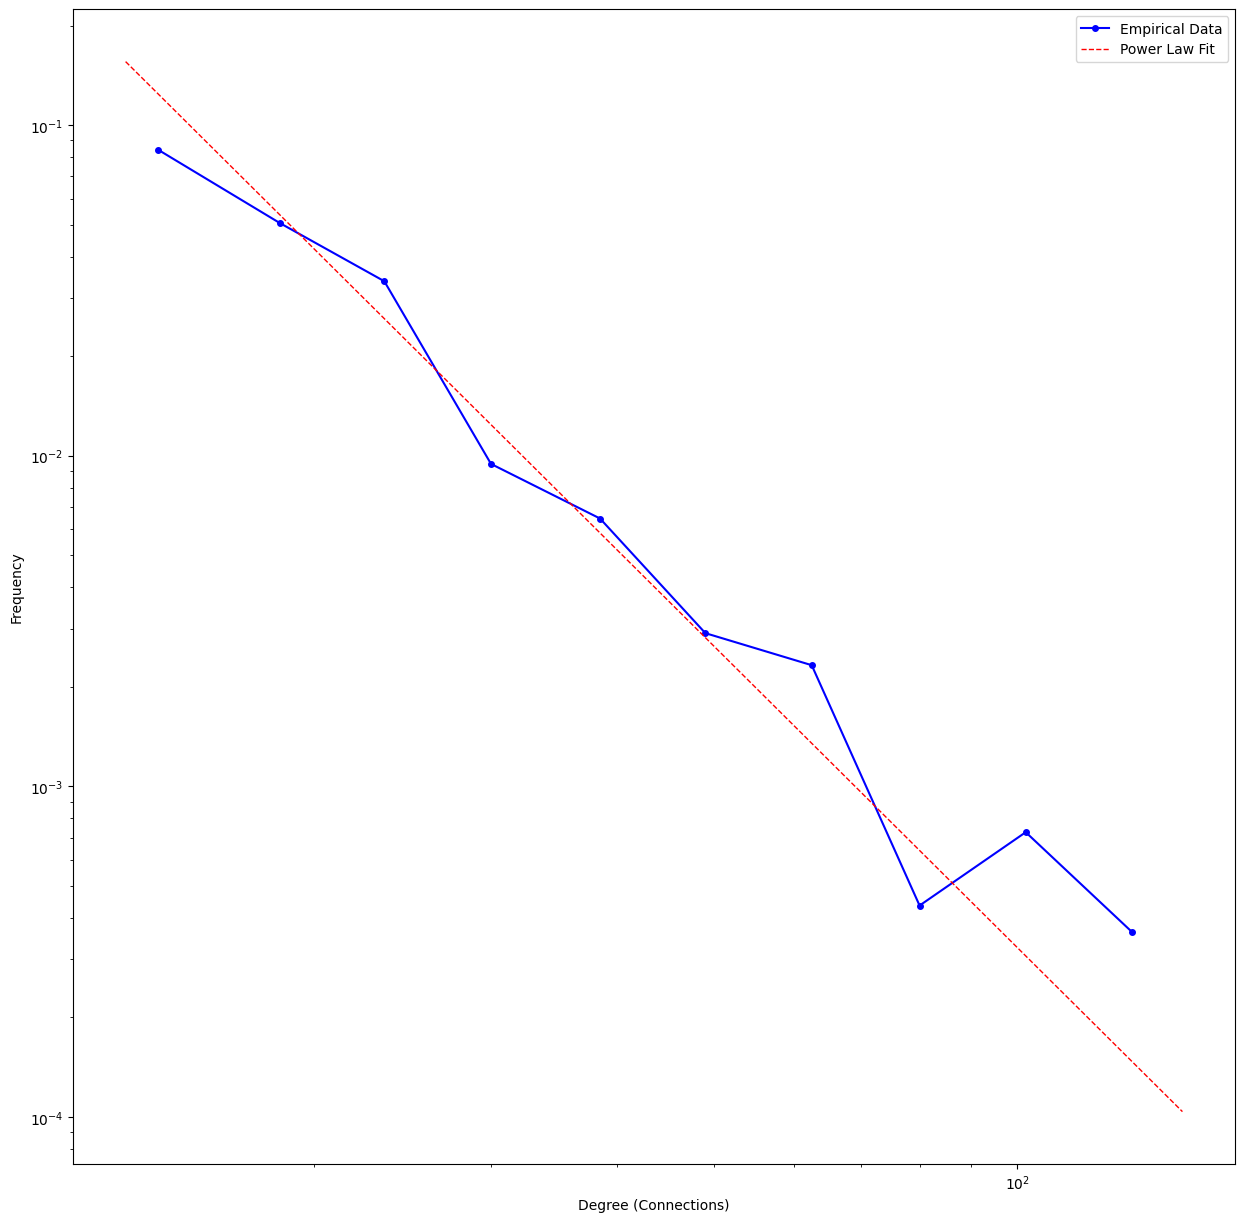

Plot for power fit for 1 saved to output_polygons/polygon_1/power_1.png
Classifier output saved to output_polygons/polygon_1/map_classifier_output_1.txt
HeadTailBreaks

    Interval       Count
------------------------
[  0.00,   2.96] | 11359
(  2.96,   5.94] |  3997
(  5.94,  11.38] |  1281
( 11.38,  23.05] |   308
( 23.05,  45.27] |    72
( 45.27,  76.79] |    22
( 76.79, 112.64] |     7
(112.64, 130.25] |     2
(130.25, 140.50] |     1
(140.50, 146.00] |     1
Plot for 1 saved to output_polygons/polygon_1/figure_1.png
Histogram for 1 saved to output_polygons/polygon_1/histogram_1.png
New GeoDataFrame for polygon at index 2 is loaded


<ipython-input-2-f75b4d7caa5f>:38: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city_stroke_gdf.to_file(shapefile_path)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke_group' to 'stroke_gro'
  ogr_write(


Calculating best minimal value for power law fit
Alpha: 3.2338219778101673
xmin: 13.0
p-value: 0.03294296162824617
-----------------------
Log-likelihood ratio (R): 91.80962074153905
p-value for comparison: 4.092260934083359e-07


Values less than or equal to 0 in data. Throwing out 0 or negative values


<Figure size 640x480 with 0 Axes>

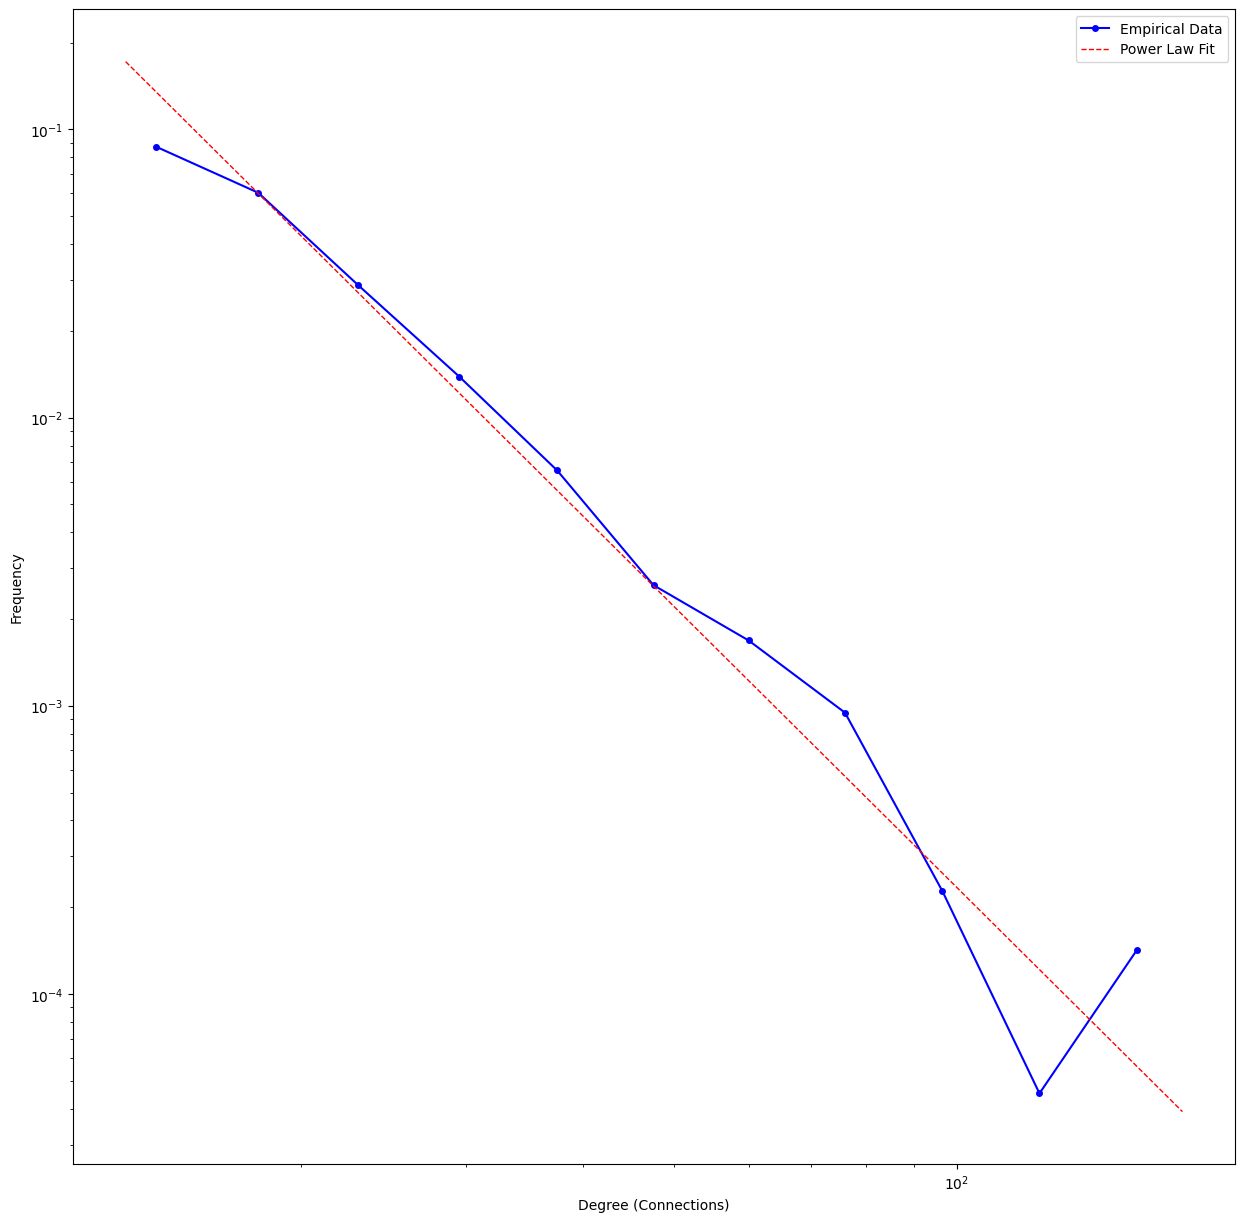

Plot for power fit for 2 saved to output_polygons/polygon_2/power_2.png
Classifier output saved to output_polygons/polygon_2/map_classifier_output_2.txt
HeadTailBreaks

    Interval       Count
------------------------
[  0.00,   3.46] | 16997
(  3.46,   8.23] |  4438
(  8.23,  16.48] |  1142
( 16.48,  29.89] |   299
( 29.89,  48.65] |    94
( 48.65,  73.98] |    31
( 73.98, 102.88] |    12
(102.88, 156.00] |     2
(156.00, 167.67] |     2
(167.67, 174.00] |     1
Plot for 2 saved to output_polygons/polygon_2/figure_2.png
Histogram for 2 saved to output_polygons/polygon_2/histogram_2.png
New GeoDataFrame for polygon at index 3 is loaded


/usr/local/lib/python3.10/dist-packages/momepy/coins.py:103: UserWarning: Lines are between points dict_keys([(441507.9121546583, 9144993.586944947), (441503.29163953813, 9144993.614353899)]) identical. Please revise input data to ensure no lines are identical or overlapping. You can check for duplicates using `gdf.geometry.duplicated()`. Assumingan angle of 0 degrees.
  self._best_link()
/usr/local/lib/python3.10/dist-packages/momepy/coins.py:103: UserWarning: Lines are between points dict_keys([(429727.972822827, 9135329.640021589), (429746.56801735447, 9135434.620394096)]) identical. Please revise input data to ensure no lines are identical or overlapping. You can check for duplicates using `gdf.geometry.duplicated()`. Assumingan angle of 0 degrees.
  self._best_link()
/usr/local/lib/python3.10/dist-packages/momepy/coins.py:103: UserWarning: Lines are between points dict_keys([(437943.37520823616, 9140515.597794283), (437935.5549425223, 9140517.511070512)]) identical. Please revise 

Calculating best minimal value for power law fit
Alpha: 3.31417589351776
xmin: 11.0
p-value: 0.029346234745272426
-----------------------
Log-likelihood ratio (R): 236.8869544567337
p-value for comparison: 1.161921472540174e-14


Values less than or equal to 0 in data. Throwing out 0 or negative values


<Figure size 640x480 with 0 Axes>

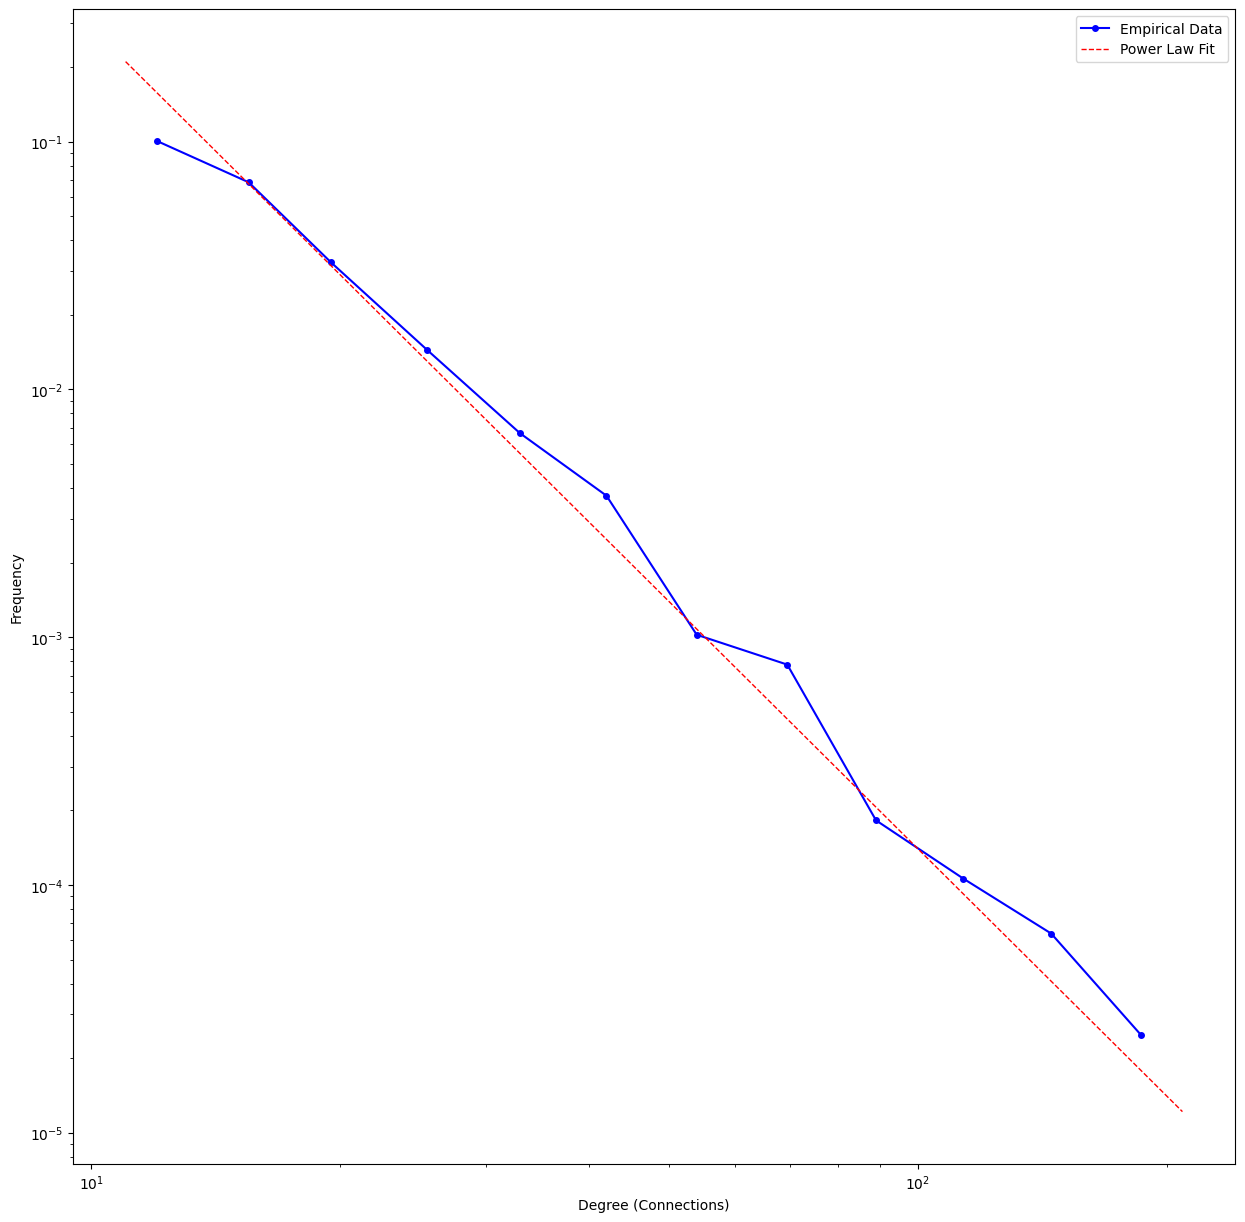

Plot for power fit for 3 saved to output_polygons/polygon_3/power_3.png
Classifier output saved to output_polygons/polygon_3/map_classifier_output_3.txt
HeadTailBreaks

    Interval       Count
------------------------
[  0.00,   3.32] | 35525
(  3.32,   7.46] |  9202
(  7.46,  14.23] |  2497
( 14.23,  26.18] |   633
( 26.18,  44.22] |   192
( 44.22,  72.92] |    45
( 72.92, 102.81] |    16
(102.81, 137.50] |     7
(137.50, 175.00] |     1
(175.00, 193.00] |     1
(193.00, 209.00] |     1
Plot for 3 saved to output_polygons/polygon_3/figure_3.png
Histogram for 3 saved to output_polygons/polygon_3/histogram_3.png
New GeoDataFrame for polygon at index 4 is loaded


<ipython-input-2-f75b4d7caa5f>:38: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city_stroke_gdf.to_file(shapefile_path)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke_group' to 'stroke_gro'
  ogr_write(


Calculating best minimal value for power law fit
Alpha: 3.4903487602831373
xmin: 11.0
p-value: 0.03875865245599963
-----------------------
Log-likelihood ratio (R): 110.80830617121146
p-value for comparison: 5.2949450206775444e-08


Values less than or equal to 0 in data. Throwing out 0 or negative values


<Figure size 640x480 with 0 Axes>

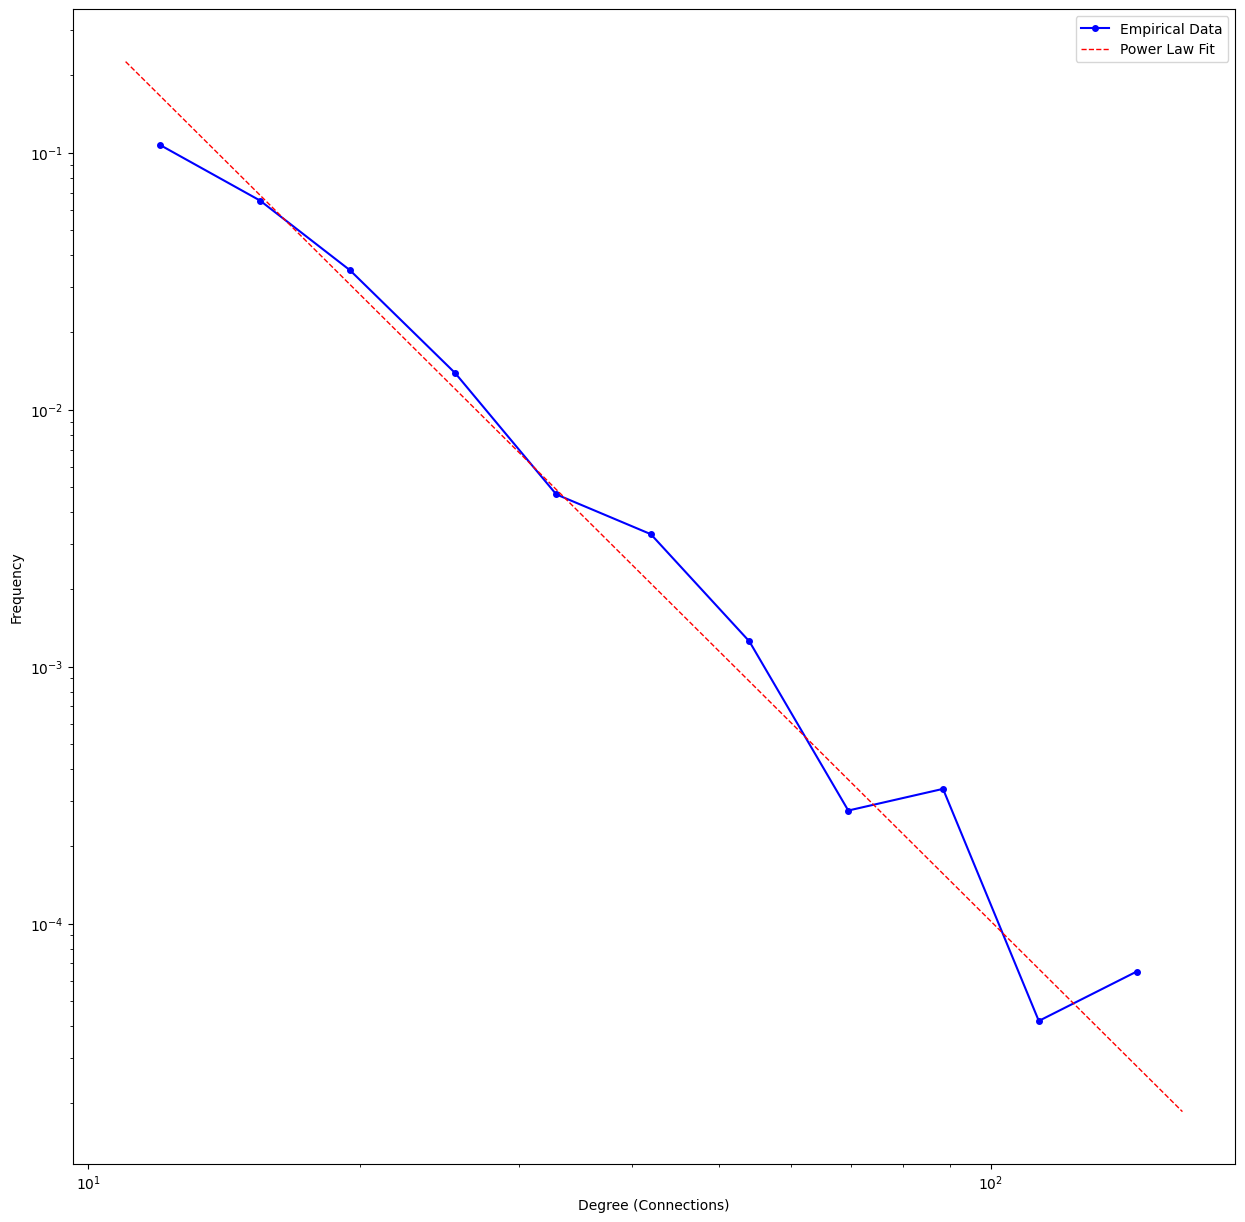

Plot for power fit for 4 saved to output_polygons/polygon_4/power_4.png
Classifier output saved to output_polygons/polygon_4/map_classifier_output_4.txt
HeadTailBreaks

    Interval       Count
------------------------
[  0.00,   3.39] | 16353
(  3.39,   7.36] |  4508
(  7.36,  13.56] |  1251
( 13.56,  23.54] |   342
( 23.54,  38.74] |    98
( 38.74,  59.43] |    34
( 59.43,  92.92] |     9
( 92.92, 129.00] |     3
(129.00, 163.00] |     1
Plot for 4 saved to output_polygons/polygon_4/figure_4.png
Histogram for 4 saved to output_polygons/polygon_4/histogram_4.png
New GeoDataFrame for polygon at index 5 is loaded


<ipython-input-2-f75b4d7caa5f>:38: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city_stroke_gdf.to_file(shapefile_path)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke_group' to 'stroke_gro'
  ogr_write(


Calculating best minimal value for power law fit
Alpha: 3.286133692290621
xmin: 9.0
p-value: 0.035999578038191093
-----------------------
Log-likelihood ratio (R): 216.44892688541975
p-value for comparison: 1.350645718512768e-20


Values less than or equal to 0 in data. Throwing out 0 or negative values


<Figure size 640x480 with 0 Axes>

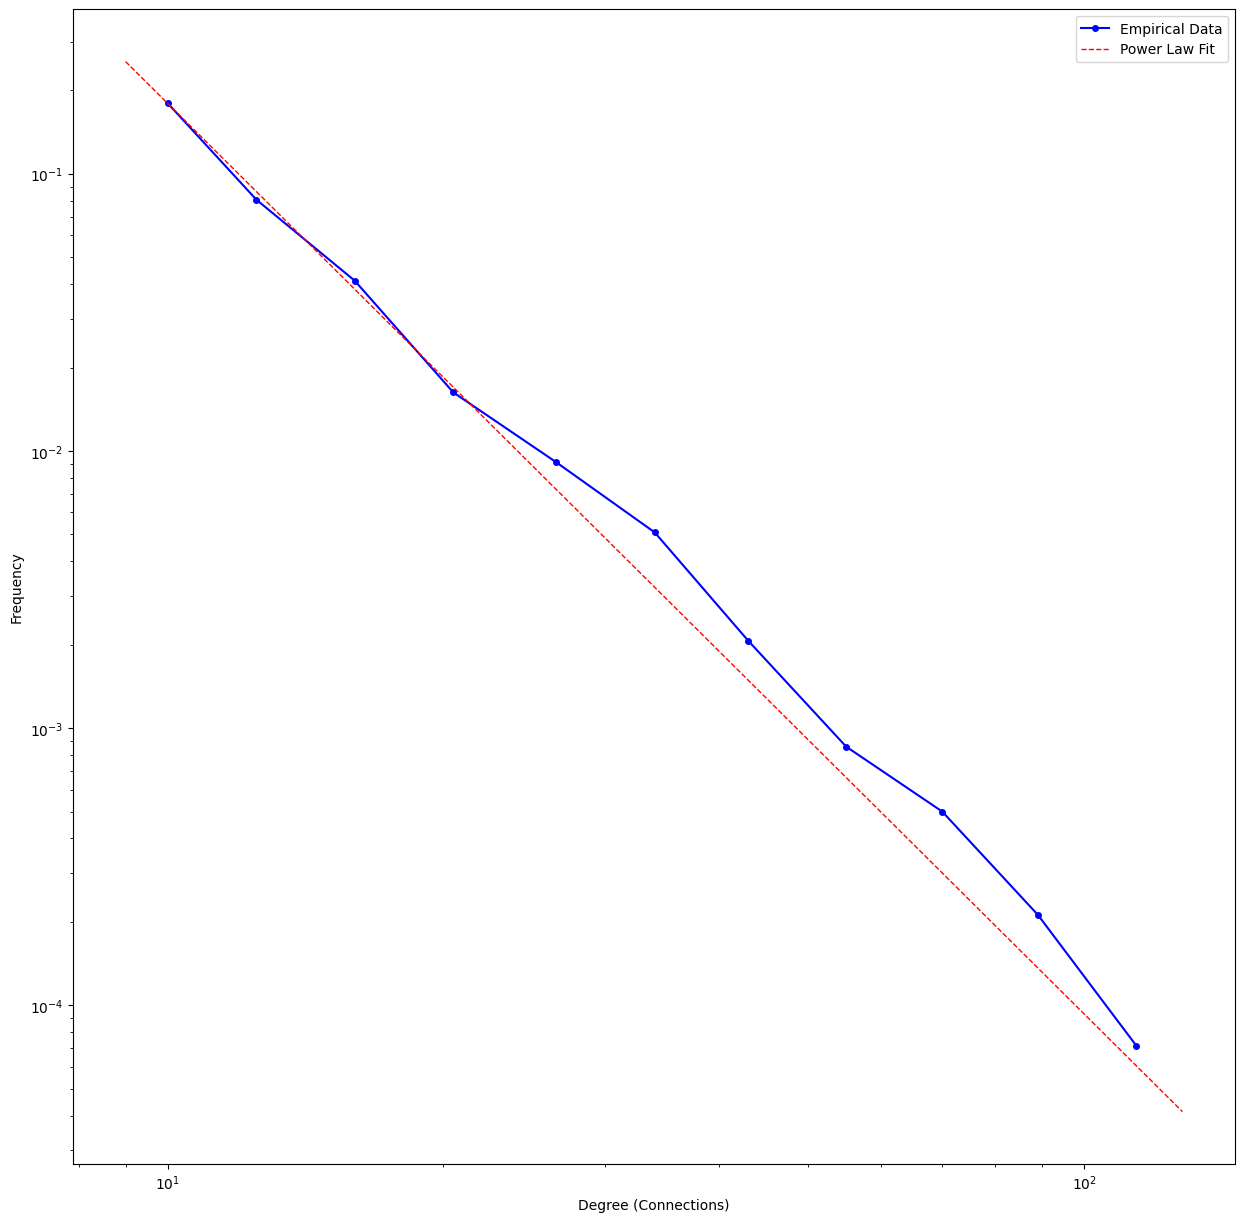

Plot for power fit for 5 saved to output_polygons/polygon_5/power_5.png
Classifier output saved to output_polygons/polygon_5/map_classifier_output_5.txt
HeadTailBreaks

    Interval       Count
------------------------
[  0.00,   2.86] | 24224
(  2.86,   5.73] |  8326
(  5.73,  10.76] |  2528
( 10.76,  19.74] |   670
( 19.74,  33.76] |   200
( 33.76,  52.14] |    59
( 52.14,  73.10] |    17
( 73.10,  87.79] |     8
( 87.79, 101.33] |     4
(101.33, 117.50] |     1
(117.50, 128.00] |     1
Plot for 5 saved to output_polygons/polygon_5/figure_5.png
Histogram for 5 saved to output_polygons/polygon_5/histogram_5.png
New GeoDataFrame for polygon at index 6 is loaded


<Figure size 640x480 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load shp file with all the polygons
all_pol = gpd.read_file("/content/drive/MyDrive/spatialanalysis/all_pol_names/all_pol_names.shp")

base_folder = "output_polygons"
os.makedirs(base_folder, exist_ok=True)  # Create base folder if it doesn't exist

# Iterate through each polygon and create a new GeoDataFrame
for index, row in all_pol.iterrows():

    # Define the folder name for the current polygon
    polygon_folder = os.path.join(base_folder, f"polygon_{index}")
    os.makedirs(polygon_folder, exist_ok=True)  # Create folder if it doesn't exist

    # Create a new GeoDataFrame for the current polygon
    new_gdf = gpd.GeoDataFrame(
        [row],
        columns=all_pol.columns,
        crs=all_pol.crs  # Retain the original CRS
    )
    polygon = new_gdf.geometry.iloc[0]  # Extract the Polygon/MultiPolygon geometry
    city_name = row['name']  # Extract the city name from the row

    # Save or process the new GeoDataFrame
    print(f"New GeoDataFrame for polygon at index {index} is loaded")
    if city_name == "Jakarta":
      next
    else:
      naturalCities(polygon,polygon_folder,city_name)





In [6]:
# Zip files for download

!zip -r /content/output_polygons.zip /content/output_polygons

  adding: content/output_polygons/ (stored 0%)
  adding: content/output_polygons/polygon_2/ (stored 0%)
  adding: content/output_polygons/polygon_2/figure_2.png (deflated 2%)
  adding: content/output_polygons/polygon_2/polygon_2.shx (deflated 55%)
  adding: content/output_polygons/polygon_2/polygon_2.dbf (deflated 90%)
  adding: content/output_polygons/polygon_2/map_classifier_output_2.txt (deflated 32%)
  adding: content/output_polygons/polygon_2/polygon_2.shp (deflated 42%)
  adding: content/output_polygons/polygon_2/power_2.png (deflated 99%)
  adding: content/output_polygons/polygon_2/polygon_2.prj (deflated 37%)
  adding: content/output_polygons/polygon_2/polygon_2.cpg (stored 0%)
  adding: content/output_polygons/polygon_2/histogram_2.png (deflated 58%)
  adding: content/output_polygons/polygon_4/ (stored 0%)
  adding: content/output_polygons/polygon_4/polygon_4.cpg (stored 0%)
  adding: content/output_polygons/polygon_4/polygon_4.prj (deflated 37%)
  adding: content/output_polyg